# Visualization and Analysis of Olive Disease Detection

This notebook analyzes the results of various models (DINOv2, DINOv3, etc.) on the Olive Diseases dataset.
It performs the following steps:
1. Loads evaluation results.
2. Calculates mAP metrics using COCO API.
3. Plots performance trends across different shots.
4. Visualizes ground truth vs. model predictions on sample images.

In [68]:
import os
import json
import random
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Paths
WORK_DIRS = '../work_dirs/olive_ablation'
DATA_DIR = '../data/olive_diseases'

# Find result files
result_paths = glob.glob(os.path.join(WORK_DIRS, '**/*.pkl'), recursive=True)
image_paths = glob.glob(os.path.join(DATA_DIR, '**/*.jpg'), recursive=True)
json_results = glob.glob(os.path.join(WORK_DIRS, '**/*.json'), recursive=True)

print(f"Found {len(json_results)} JSON result files.")
print(f"Found {len(image_paths)} images.")

Found 50 JSON result files.
Found 1369 images.


## Load Ground Truth

We load the COCO-format ground truth annotations for the validation set.
Values are checked to ensure data integrity.

In [69]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

ann_file = os.path.join(DATA_DIR, 'annotations/instances_val2017.json')
if not os.path.exists(ann_file):
    print(f"Annotation file not found at {ann_file}")
else:
    coco_gt = COCO(ann_file)
    img_ids = coco_gt.getImgIds()
    print(f"Loaded {len(img_ids)} images from Ground Truth.")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded 206 images from Ground Truth.


## Evaluate Models

We iterate through all result JSON files, evaluate them against the ground truth using standard COCO metrics, and compile the results into a DataFrame.

In [70]:
evaluation_results = []

print(f"Evaluating {len(json_results)} result files...")

for i, res_file in enumerate(json_results):
    if 'results.json' not in res_file:
        continue
    
    # Load and evaluate
    coco_dt = coco_gt.loadRes(res_file)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    # Store results
    stats = coco_eval.stats
    evaluation_results.append({
        'file': res_file,
        'mAP_0.5:0.95': stats[0],
        'mAP_0.5': stats[1],
        'mAP_0.75': stats[2],
        'mAP_small': stats[3],
        'mAP_medium': stats[4],
        'mAP_large': stats[5]
    })

df_results = pd.DataFrame(evaluation_results)
print(f"Evaluation complete. Rows: {len(df_results)}")
df_results.head()

Evaluating 50 result files...
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.256
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0

,file,mAP_0.5:0.95,mAP_0.5,mAP_0.75,mAP_small,mAP_medium,mAP_large
0,../work_dirs/olive_ablation/dinov3_2shot/resul...,0.220407,0.290070,0.236408,0.034738,0.204264,0.256193
1,../work_dirs/olive_ablation/dinov3_3shot/resul...,0.210521,0.282877,0.224274,0.040218,0.195737,0.235635
2,../work_dirs/olive_ablation/dinov3_small_5shot...,0.196640,0.254088,0.215918,0.010807,0.131314,0.251242
3,../work_dirs/olive_ablation/dinov2_base_10shot...,0.292949,0.403122,0.313328,0.085777,0.285154,0.318182
4,../work_dirs/olive_ablation/dinov3_1shot/resul...,0.130184,0.178978,0.133717,0.024990,0.110847,0.162393


## Analysis Results

Sort and display the top performing models.

In [71]:
if not df_results.empty:
    sorted_df = df_results.sort_values(by='mAP_0.5:0.95', ascending=False)
    # Display top 10
    display(sorted_df[['file', 'mAP_0.5:0.95', 'mAP_0.5']].head(10))
else:
    print("No results to display.")

,file,mAP_0.5:0.95,mAP_0.5
3,../work_dirs/olive_ablation/dinov2_base_10shot...,0.292949,0.403122
45,../work_dirs/olive_ablation/dinov2_large_10sho...,0.282229,0.387711
43,../work_dirs/olive_ablation/dinov2_10shot/resu...,0.282229,0.387711
9,../work_dirs/olive_ablation/dinov2_base_5shot/...,0.279539,0.378835
20,../work_dirs/olive_ablation/dinov2_giant_10sho...,0.276314,0.376889
13,../work_dirs/olive_ablation/dinov2_large_5shot...,0.269160,0.362606
24,../work_dirs/olive_ablation/dinov2_5shot/resul...,0.269160,0.362606
40,../work_dirs/olive_ablation/dinov2_small_10sho...,0.267482,0.358471
11,../work_dirs/olive_ablation/dinov2_giant_5shot...,0.264644,0.354028
32,../work_dirs/olive_ablation/dinov3_large_10sho...,0.257906,0.352611


## Performance Plot

We parse the filenames to extract model names and shot counts, then plot the mAP metrics to visualize the impact of few-shot examples.

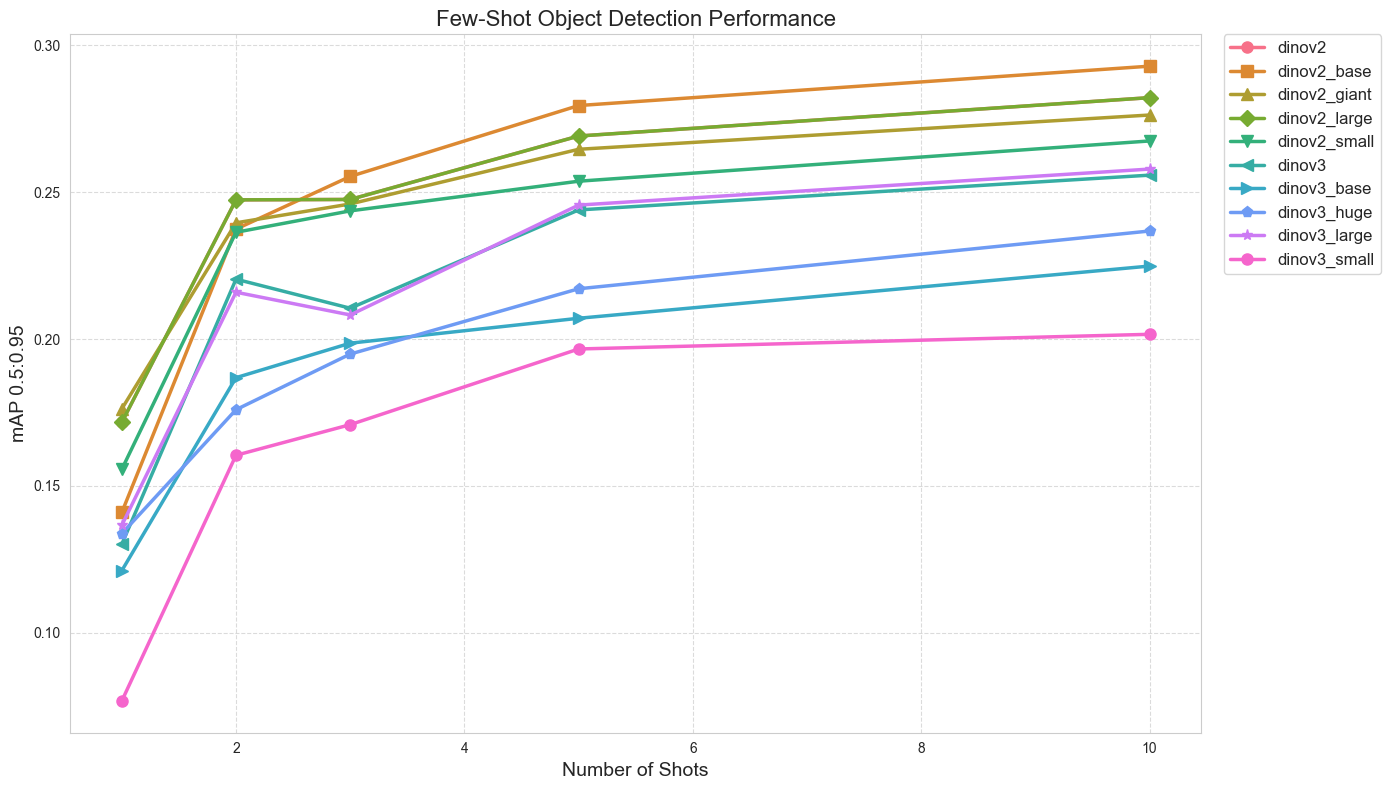

In [72]:
def parse_filename(filepath):
    # Adjust regex if your folder structure is different
    # Assumes structure: .../olive_ablation/<model_name>_<shots>shot/...
    match = re.search(r'olive_ablation/([^/]+)_(\d+)shot', filepath)
    if match:
        return match.group(1), int(match.group(2))
    return "unknown", 0

if not df_results.empty:
    df_results['model'], df_results['shots'] = zip(*df_results['file'].map(parse_filename))
    
    # Filter out unknowns if any
    plot_df = df_results[df_results['model'] != "unknown"].copy()

    plt.figure(figsize=(14, 8))
    
    # Get unique models
    models = sorted(plot_df['model'].unique())
    
    # Define markers and colors
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']
    # Use a distinct palette
    palette = sns.color_palette("husl", len(models))
    
    for i, model_name in enumerate(models):
        subset = plot_df[plot_df['model'] == model_name].sort_values(by='shots')
        marker = markers[i % len(markers)]
        plt.plot(subset['shots'], subset['mAP_0.5:0.95'], 
                 marker=marker, label=model_name, linewidth=2.5, markersize=8, color=palette[i])

    plt.xlabel('Number of Shots', fontsize=14)
    plt.ylabel('mAP 0.5:0.95', fontsize=14)
    plt.title('Few-Shot Object Detection Performance', fontsize=16)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

## Visualizations

We visualize the predictions of the best performing model on random validation images.
Ground truth annotations are shown in green, and model predictions in blue.

Visualizing results for best model: dinov2_base_10shot (mAP=0.293)


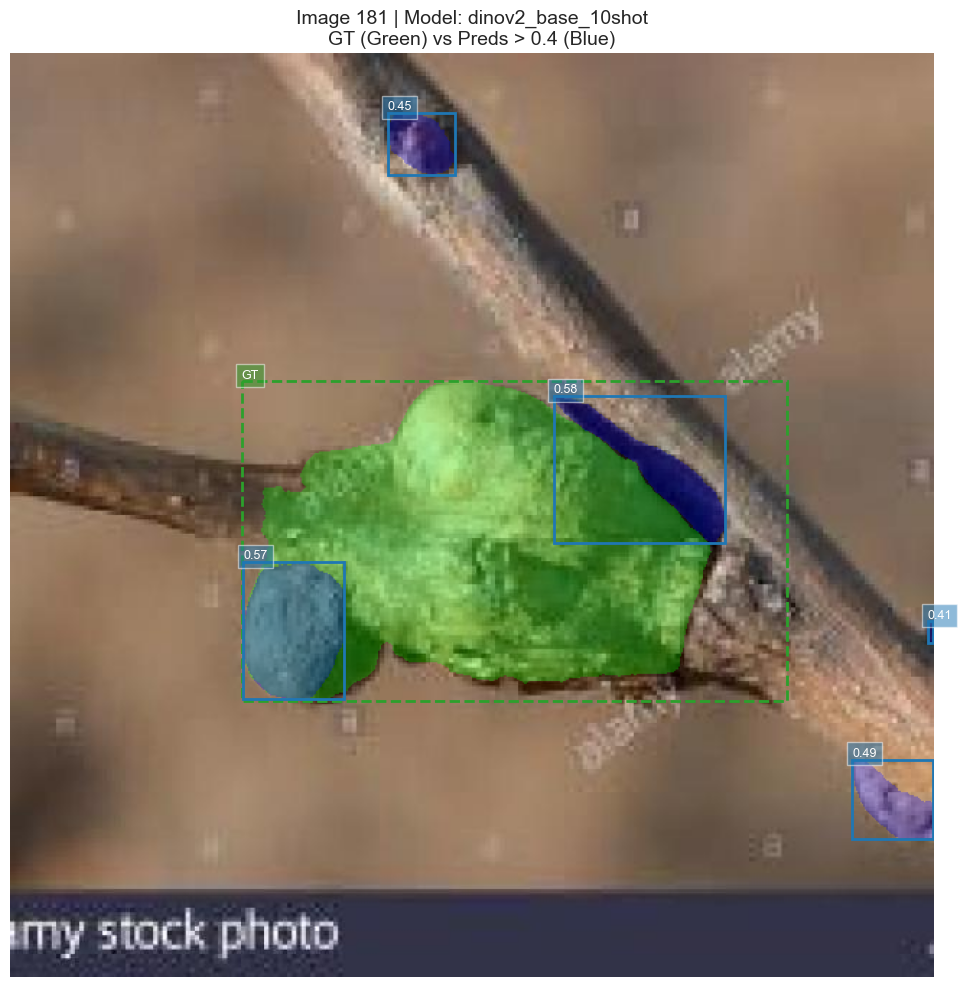

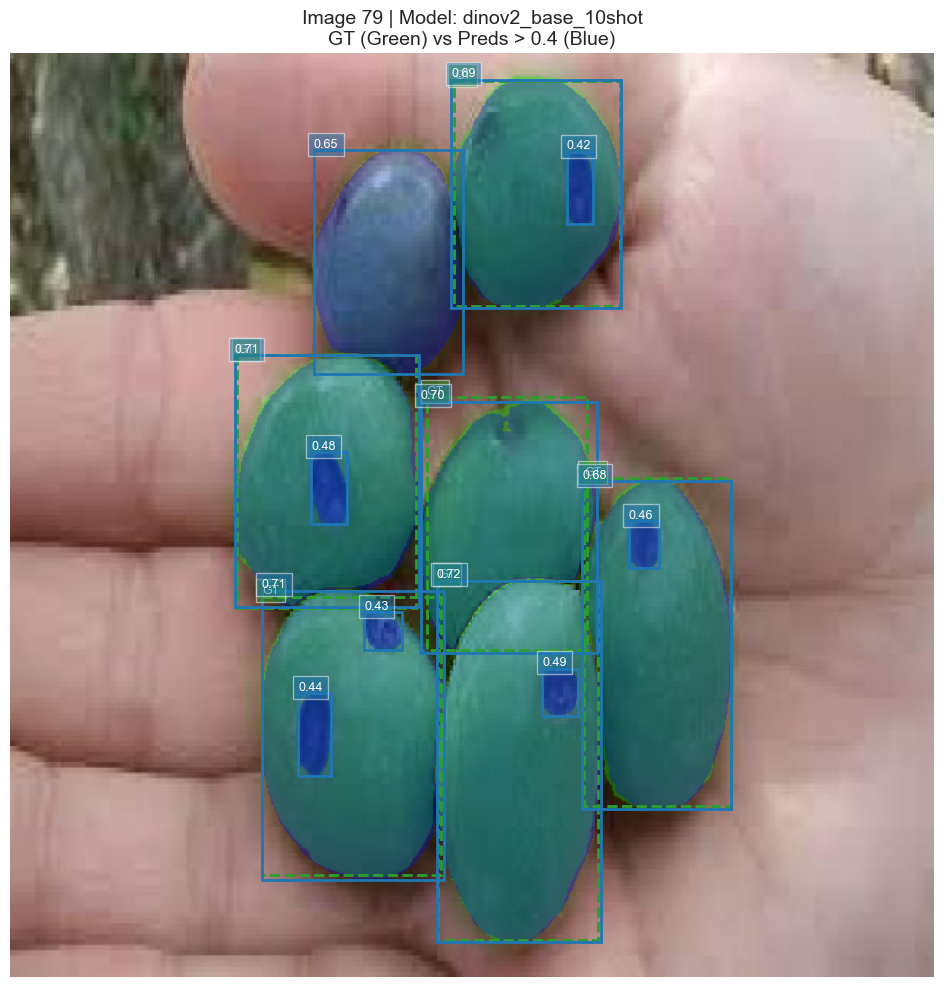

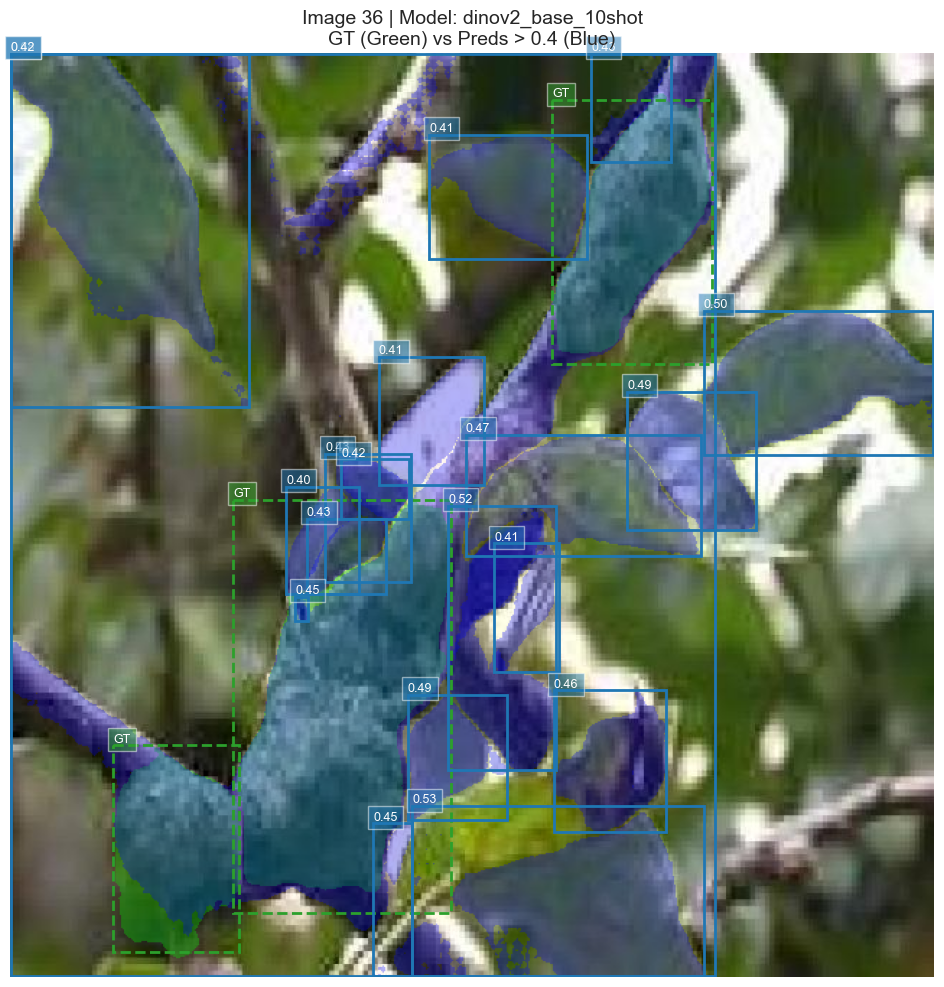

In [73]:
from pycocotools import mask as mask_utils

def get_image_path(filename, image_paths):
    # Retrieve the full path for a given filename
    for path in image_paths:
        if filename in path: # safer loose match or exact logic
             return path
    return None

def apply_mask(image, mask, color, alpha=0.5):
    """Apply colored mask to image."""
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def visualize_prediction(img_id, res_file, coco_gt, image_paths, score_thr=0.4):
    # Load predictions
    with open(res_file, 'r') as f:
        predictions = json.load(f)
    
    # Filter predictions for this image
    img_preds = [p for p in predictions if p['image_id'] == img_id and p['score'] > score_thr]
    
    # Load ground truth
    img_info = coco_gt.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    img_path = get_image_path(file_name, image_paths)
    
    if img_path is None or not os.path.exists(img_path):
        print(f"Image {file_name} not found.")
        return

    # Read image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    img_float = img.astype(float)

    # Draw Ground Truth Masks (Green)
    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)
    for ann in anns:
        if 'segmentation' in ann:
            m = coco_gt.annToMask(ann)
            img_float = apply_mask(img_float, m, color=(0, 1, 0), alpha=0.3) 

    # Draw Prediction Masks (Blue)
    for p in img_preds:
        if 'segmentation' in p:
            rle = p['segmentation']
            if isinstance(rle, list): # Polygon format
                    m = mask_utils.decode(mask_utils.frPyObjects(rle, img.shape[0], img.shape[1]))
            else: # RLE format
                    m = mask_utils.decode(rle)
            
            if len(m.shape) == 3:
                    m = m[:, :, 0]
            img_float = apply_mask(img_float, m, color=(0, 0, 1), alpha=0.3)

    # Convert back to uint8 for display
    img_display = img_float.astype(np.uint8)
    plt.imshow(img_display)
    
    # Draw GT Bboxes (Green Dashed)
    for ann in anns:
        bbox = ann['bbox']
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='#2ca02c', linewidth=2, linestyle='--')
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1]-2, "GT", bbox=dict(facecolor='#2ca02c', alpha=0.5), fontsize=9, color='white')

    # Draw Prediction Bboxes (Blue Solid)
    for p in img_preds:
        bbox = p['bbox']
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='#1f77b4', linewidth=2)
        ax.add_patch(rect)
        ax.text(bbox[0], bbox[1]-2, f"{p['score']:.2f}", bbox=dict(facecolor='#1f77b4', alpha=0.5), fontsize=9, color='white')

    model_display_name = os.path.basename(os.path.dirname(res_file))
    plt.title(f"Image {img_id} | Model: {model_display_name}\nGT (Green) vs Preds > {score_thr} (Blue)", fontsize=14)
    plt.axis('off')
    plt.show()

# Select best model dynamically
if not df_results.empty:
    best_row = df_results.loc[df_results['mAP_0.5:0.95'].idxmax()]
    best_model_file = best_row['file']
    print(f"Visualizing results for best model: {os.path.basename(os.path.dirname(best_model_file))} (mAP={best_row['mAP_0.5:0.95']:.3f})")

    # Pick random images
    random_img_ids = random.sample(img_ids, 3) # Visualizing 3 examples
    for img_id in random_img_ids:
        visualize_prediction(img_id, best_model_file, coco_gt, image_paths)
else:
    print("No results to visualize.")

# Conclusions

Based on the generated plots and tables:
- **Best Model:** Check the sort order in the table above. Typically, larger backbones or higher shot counts yield better performance.
- **Shot scaling:** Observe the trend in the "Few-Shot Performance" plot. Does performance saturate after a certain number of shots?
- **Visual Quality:** In the visualizations, check if the model detects the disease lesions accurately or if there are false positives (blue boxes with no underlying green annotation).